In [1]:
from PIL import Image
from PIL import ImageFilter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def image_to_np_array(image_path):
    return np.asarray(Image.open(image_path))

In [3]:
image = Image.open('input_clock.jpg')
image_np = image_to_np_array("input_clock.jpg")

In [4]:
def resize_image(image_np_array, shape):
    PIL_image = Image.fromarray(np.uint8(image_np_array)).convert('RGB')
    PIL_image = PIL_image.resize(shape)
    return np.array(PIL_image)

In [5]:
resized_image = resize_image(image_np, (600, 800))
PIL_image = Image.fromarray(np.uint8(resized_image)).convert('RGB')
PIL_image.save('input_clock_resized.jpg')

In [6]:
def pad_image_with_white(image_np_array, border_size):
    max_row = image_np_array.shape[0]
    max_col = image_np_array.shape[1]
    padded_image = np.ones((max_row + 2*border_size, max_col + 2*border_size, 3), dtype='uint8') * 255
    padded_image[border_size:border_size+max_row, border_size:border_size+max_col, :] = image_np_array
    return padded_image

In [7]:
def plot_image(img: np.array):
    plt.figure(figsize=(6, 6))
    plt.imshow(img.astype('uint8'))

In [8]:
def plot_images_side_by_side(images_array, image_names, mse):
    n = len(images_array)
    _, ax = plt.subplots(1, n, figsize=(18, 8))
    for i in range(n):
        ax[i].set_title(image_names[i])
        ax[i].imshow(images_array[i].astype('uint8'))
    plt.suptitle(f"MSE between the convolution and the reference image is: {mse}")
    plt.tight_layout()

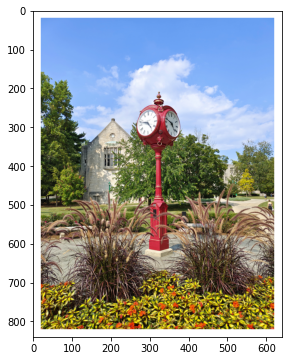

In [9]:
padded_image = pad_image_with_white(resized_image, 20)
plot_image(padded_image) # White padded on 4 sides with 20 pixels

In [10]:
def custom_convolution(image_path, kernel=np.ones((3,3)), output_filename = "demo_output.jpg"):
    # Decide the border size. Assume a kernel is square and has odd_number * odd_number of elements.
    kernel_size = kernel.shape[0]
    if(kernel_size <= 1):
        border_size = 0
    else:
        border_size = kernel_size // 2

    image_np = image_to_np_array(image_path)

    resize_shape = (600, 800)

    resized_image = resize_image(image_np, resize_shape)
    padded_image = pad_image_with_white(resized_image, border_size)

    # print(f"Before filtering, resized and padded image shape: {padded_image.shape}, border size: {border_size}")
    # plot_image(padded_image)
    target_row = padded_image.shape[0] - (2*border_size)
    target_col = padded_image.shape[1] - (2*border_size)
    result_image = np.zeros((target_row, target_col, 3))

    for rgb_index in range(3):
        for i in range(target_row):
            for j in range(target_col):
                mat = padded_image[i:i+kernel_size, j:j+kernel_size, rgb_index]
                result_image[i][j][rgb_index] = np.sum(np.multiply(mat, kernel))
    
    if np.min(result_image) < 0:
        np.clip(result_image, 0, 255, out=result_image)
    
    # print(f"Target shape is {result_image.shape}")
    result_image = result_image.astype('uint8')
    return result_image

In [11]:
def get_sharpen_filter(alpha, identity_filter, approximated_gaussian):
    sharpen = np.zeros((5,5))
    sharpen[1:4, 1:4] = identity_filter
    sharpen = ((1+alpha) * sharpen) - approximated_gaussian
    return sharpen

In [12]:
def get_all_kernels():
    kernel_dict = dict()
    identity_filter = np.zeros((3,3))
    identity_filter[1][1] = 1
    kernel_dict['a.jpg'] = identity_filter

    box_blur = np.ones((3,3)) * 1/9
    kernel_dict['b.jpg'] = box_blur

    horizontal_derivative = np.zeros((3,3))
    horizontal_derivative[1][0] = -1
    horizontal_derivative[1][2] = 1
    kernel_dict['c.jpg'] = horizontal_derivative

    approximated_gaussian = np.array([
        [0.003, 0.013, 0.022, 0.013, 0.003],
        [0.013, 0.059, 0.097, 0.059, 0.013],
        [0.022, 0.097, 0.159, 0.097, 0.022],
        [0.013, 0.059, 0.097, 0.059, 0.013],
        [0.003, 0.013, 0.022, 0.013, 0.003]
    ])
    kernel_dict['d.jpg'] = approximated_gaussian

    kernel_dict['e.jpg'] = get_sharpen_filter(0.9, identity_filter, approximated_gaussian)

    gaussian_derivative = np.zeros((5,5))
    gaussian_derivative[1:4, 1:4] = horizontal_derivative
    gaussian_derivative = gaussian_derivative * approximated_gaussian
    kernel_dict['f.jpg'] = gaussian_derivative

    return kernel_dict

In [13]:
names = ["Identity", "Box blur", "Horizontal derivative", "Approximated Gaussian", "Sharpening", "Derivative of Gaussian"]
kernels = list(get_all_kernels().values())
for name, kernel in zip(names, kernels):
    print(f"The {name} kernel is: \n{kernel}\n")

The Identity kernel is: 
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]

The Box blur kernel is: 
[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]

The Horizontal derivative kernel is: 
[[ 0.  0.  0.]
 [-1.  0.  1.]
 [ 0.  0.  0.]]

The Approximated Gaussian kernel is: 
[[0.003 0.013 0.022 0.013 0.003]
 [0.013 0.059 0.097 0.059 0.013]
 [0.022 0.097 0.159 0.097 0.022]
 [0.013 0.059 0.097 0.059 0.013]
 [0.003 0.013 0.022 0.013 0.003]]

The Sharpening kernel is: 
[[-0.003 -0.013 -0.022 -0.013 -0.003]
 [-0.013 -0.059 -0.097 -0.059 -0.013]
 [-0.022 -0.097  1.741 -0.097 -0.022]
 [-0.013 -0.059 -0.097 -0.059 -0.013]
 [-0.003 -0.013 -0.022 -0.013 -0.003]]

The Derivative of Gaussian kernel is: 
[[ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.    -0.097  0.     0.097  0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]]



In [14]:
def reference_outputs(image_np):
    image = Image.fromarray(np.uint8(image_np)).convert('RGB')
    all_reference_outputs = []
    kernels = list(get_all_kernels().values())
    for kernel in kernels:
        shape = kernel.shape
        pil_identity = image.filter(ImageFilter.Kernel(shape, kernel.flatten(), sum(kernel.flatten())))
        all_reference_outputs.append(np.asarray(pil_identity))
    return all_reference_outputs

In [15]:
original_image_np = image_to_np_array('input_clock.jpg')
image_np = resize_image(original_image_np, (600, 800))
reference_images = reference_outputs(image_np)

In [16]:
kernels = get_all_kernels()
convoluted_images = []
for filename, kernel in kernels.items():
    convoluted_images.append(custom_convolution('input_clock.jpg', kernel, filename))

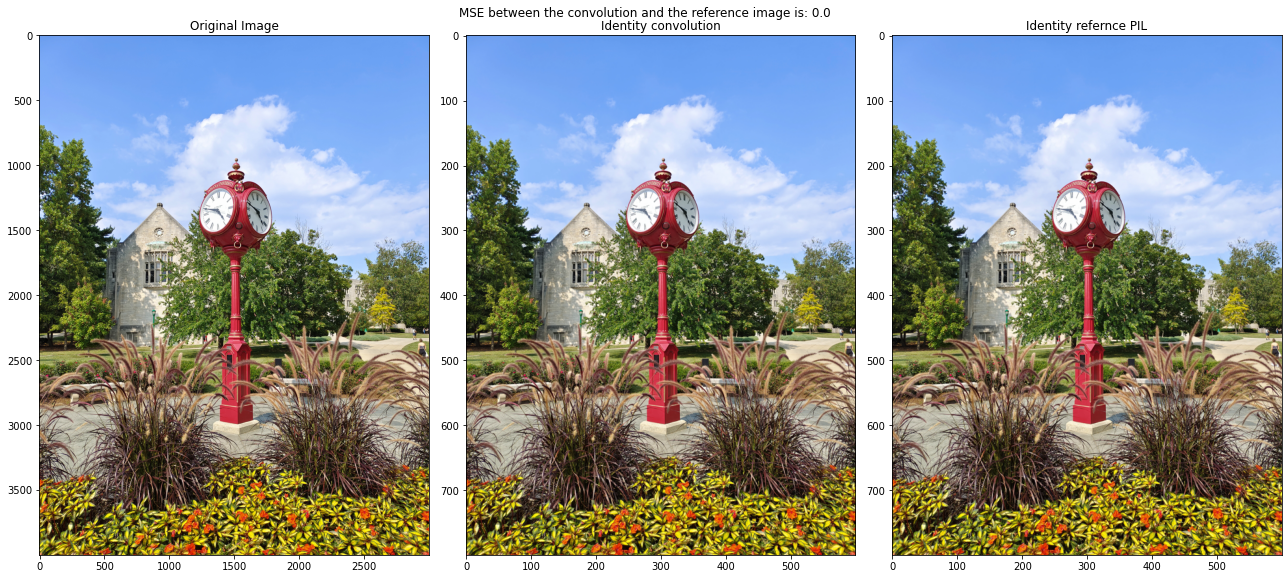

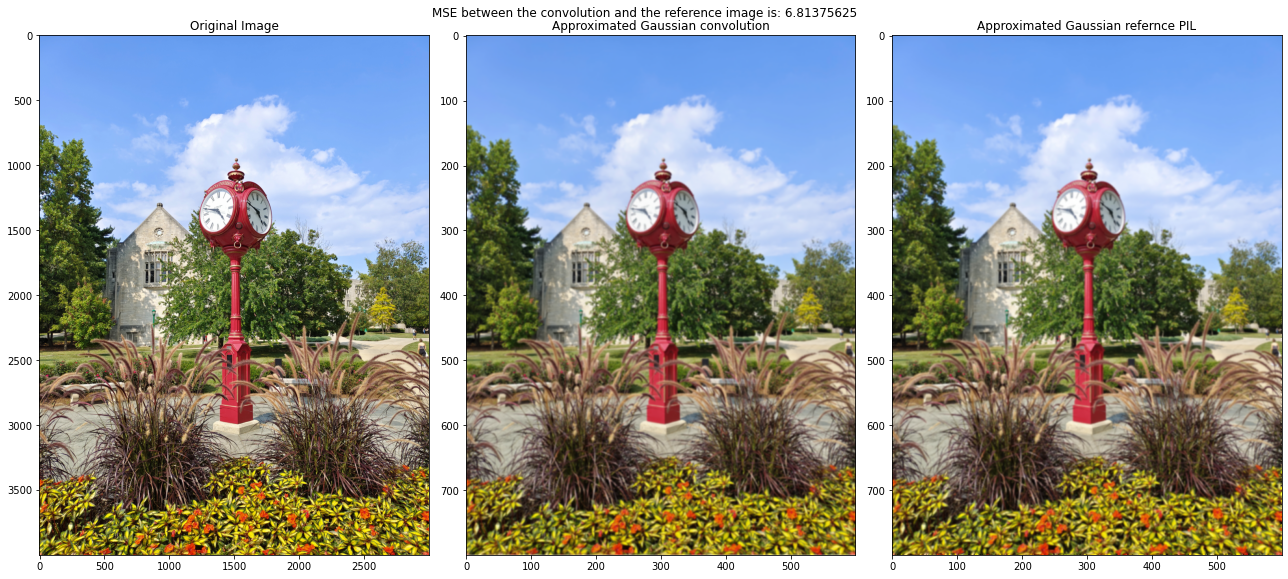

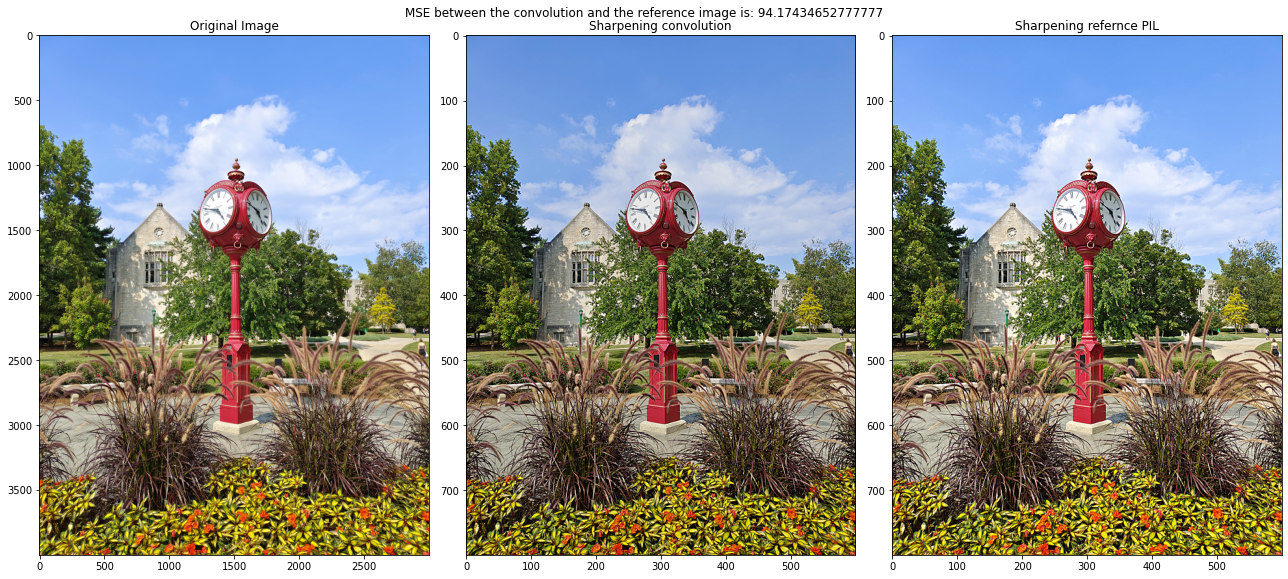

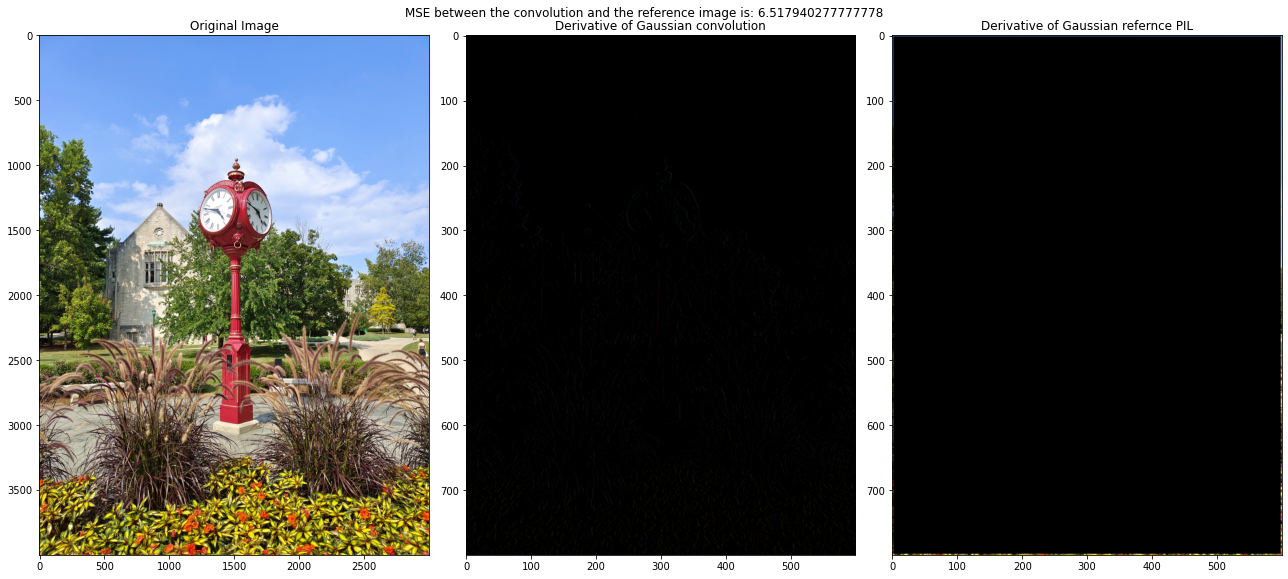

In [17]:
from sklearn.metrics import mean_squared_error
all_image_names = [['Original Image', 'Identity convolution', 'Identity refernce PIL'],
                    ['Original Image', 'Box blur convolution', 'Box blur refernce PIL'],
                    ['Original Image', 'Horizontal derivative convolution', 'Horizontal derivative refernce PIL'],
                    ['Original Image', 'Approximated Gaussian convolution', 'Approximated Gaussian refernce PIL'],
                    ['Original Image', 'Sharpening convolution', 'Sharpening refernce PIL'],
                    ['Original Image', 'Derivative of Gaussian convolution', 'Derivative of Gaussian refernce PIL']]
for actual, pil_reference, image_names in zip(convoluted_images, reference_images, all_image_names):
    mse = mean_squared_error(actual.flatten(), pil_reference.flatten())
    plot_images_side_by_side([original_image_np, actual, pil_reference], image_names, mse)